In [1]:
import ctypes
import numpy             as np
import matplotlib.pyplot as plt
from   tqdm              import tqdm

### Importing C functions

In [2]:
_it = ctypes.CDLL('src/libit.so')

#### Entropy from probabilities

In [3]:
_it.entropyfromprobabilities.argtypes = (ctypes.POINTER(ctypes.c_float), ctypes.c_int)
_it.entropyfromprobabilities.restype  = ctypes.c_float

Below we create a wrapper for the __entropyfromprobabilities__ C method.

In [4]:
def entropyfromprobabilities(p):
    global _it
    n_bins     = len(p)
    array_type = ctypes.c_float * n_bins
    H          = _it.entropyfromprobabilities(array_type(*p), ctypes.c_int(n_bins))
    return float(H)

#### Entropy for spike trains

In [5]:
_it.BinEntropy.argtypes = (ctypes.POINTER(ctypes.c_int), ctypes.c_int)
_it.BinEntropy.restype  = ctypes.c_float

In [6]:
def BinEntropy(x):
    global _it
    n_bins     = len(x)
    array_type = ctypes.c_int * n_bins
    H          = _it.BinEntropy(array_type(*x), ctypes.c_int(n_bins))
    return float(H)

In [7]:
# Function to generate the binary time series
def generate_series(p_1 = 0, size = 1000):
    r = np.random.rand(size)
    return (r > p_1).astype(int)

In [8]:
# Probabilities of p(1)
probabilities = np.linspace(0, 1, 20)
# Computing entropy
H = [BinEntropy(generate_series(p_1 = p, size = 5000)) for p in probabilities]

Text(0.5, 0, 'probabilities')

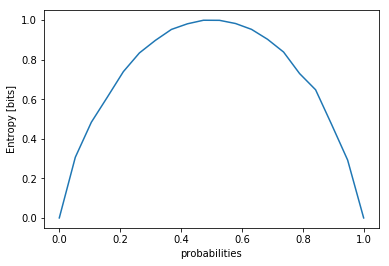

In [9]:
plt.figure(figsize=(6,4))
plt.plot(probabilities, H)
plt.ylabel('Entropy [bits]')
plt.xlabel('probabilities')

#### Joint entropy

In [10]:
_it.BinJointEntropy.argtypes = (ctypes.POINTER(ctypes.c_int), ctypes.POINTER(ctypes.c_int),ctypes.c_int)
_it.BinJointEntropy.restype  = ctypes.c_float

In [11]:
def BinJointEntropy(x,y):
    if len(x) != len(y):
        raise ValueError('Inputs x and y should have the same length')
    global _it
    n_bins     = len(x)
    array_type = ctypes.c_int * n_bins
    Hxy        = _it.BinJointEntropy(array_type(*x), array_type(*y),ctypes.c_int(n_bins))
    return float(Hxy)

In [12]:
def gen_coupled_series(N=1000,rho=0):
    cov = [[1, rho], 
           [rho, 1]]
    X   = np.random.multivariate_normal((0,0), cov, size=N).T
    return (X[0]>.5).astype(int), (X[1]> .5).astype(int)

In [13]:
rho_list = np.linspace(0,1,100)
Hx       = np.zeros_like(rho_list)
Hy       = np.zeros_like(rho_list)
Hxy      = np.zeros_like(rho_list)
for i in tqdm( range( len(rho_list) ) ):
    x,y    = gen_coupled_series(N=100000, rho=rho_list[i])
    Hx[i]  = BinEntropy(x)
    Hxy[i] = BinJointEntropy(x,y)/Hx[i]

100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


Text(0.5, 0, '$\\rho$')

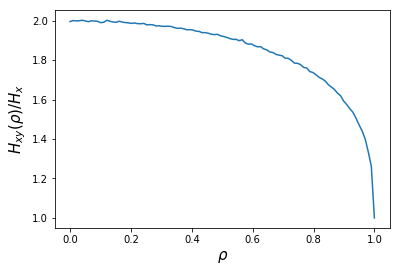

In [14]:
plt.plot(rho_list, Hxy)
plt.ylabel(r'$H_{xy}(\rho)/H_{x}$', fontsize=15)
plt.xlabel(r'$\rho$', fontsize=15)

#### Mutual information

In [15]:
_it.BinMutualInformation.argtypes = (ctypes.POINTER(ctypes.c_int), ctypes.POINTER(ctypes.c_int),ctypes.c_int)
_it.BinMutualInformation.restype  = ctypes.c_float

In [16]:
def BinMutualInformation(x,y):
    if len(x) != len(y):
        raise ValueError('Inputs x and y should have the same length')
    global _it
    n_bins     = len(x)
    array_type = ctypes.c_int * n_bins
    MI         = _it.BinMutualInformation(array_type(*x), array_type(*y),ctypes.c_int(n_bins))
    return float(MI)

In [17]:
rho_list = np.linspace(0,1,100)
MI      = np.zeros_like(rho_list)
for i in tqdm( range( len(rho_list) ) ):
    x,y    = gen_coupled_series(N=100000, rho=rho_list[i])
    MI[i] = BinMutualInformation(x,y)

100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Text(0.5, 0, '$\\rho$')

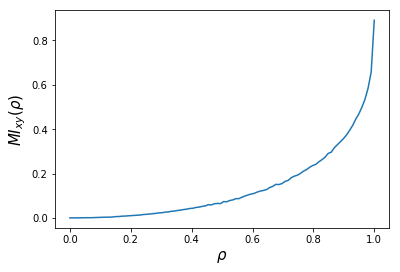

In [19]:
plt.plot(rho_list, MI)
plt.ylabel(r'$MI_{xy}(\rho)$', fontsize=15)
plt.xlabel(r'$\rho$', fontsize=15)

In [21]:
def BinLaggedMutualInformation(x,y,lag=0):
    if len(x) != len(y):
        raise ValueError('Inputs x and y should have the same length')
    global _it
    if lag == 0:
        return BinMutualInformation(x,y)
    else:
        if lag > 0:
            x_lagged = x[lag:]
            y_lagged = y[:-lag]
        elif lag < 0:
            x_lagged = x[:lag]
            y_lagged = y[-lag:]            
        return BinMutualInformation(x_lagged,y_lagged)

In [42]:
def gen_lagged_series(N=1000, lag=0, rho = 0):
    x = np.random.rand(N)
    y = np.random.rand(N)
    y[:-lag] = y[:-lag] + rho * x[lag:]
    return (x>.5).astype(int), (y>.5).astype(int)

In [43]:
rho_list = np.array([0, 0.5, 1, 5, 10])
lags     = np.arange(-10,11,1, dtype=int)
MI       = np.zeros([len(rho_list), len(lags)])
for i in tqdm( range(len(rho_list)) ):
    x, y = gen_lagged_series(N=10000, lag=5, rho = rho_list[i])
    MI[i,:] = [BinLaggedMutualInformation(x,y,lag) for lag in lags]

100%|██████████| 5/5 [00:00<00:00,  6.68it/s]


100%|██████████| 5/5 [00:00<00:00, 127.60it/s]


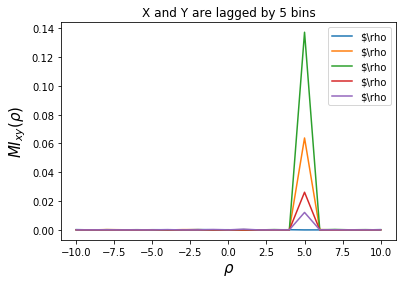

In [45]:
for i in tqdm( range(len(rho_list)) ):
    plt.plot(lags, MI[i], label = r'$\rho')
plt.title('X and Y are lagged by 5 bins')
plt.ylabel(r'$MI_{xy}(\rho)$', fontsize=15)
plt.xlabel(r'$\rho$', fontsize=15)
plt.legend()